# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Include transformations and interactions, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
6. Summarize your results from 1 to 5. Have you learned anything about overfitting and underfitting, or model selection?
7. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.



In [1]:
! pip install pandas numpy seaborn


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


1. Clean the data and perform some EDA and visualization to get to know the data set.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df = pd.read_csv('airbnb_hw.csv')
df.head()

,Host Id,Host Since,Name,Neighbourhood,Property Type,Review Scores Rating (bin),Room Type,Zipcode,Beds,Number of Records,Number Of Reviews,Price,Review Scores Rating
0,5162530,NaN,1 Bedroom in Prime Williamsburg,Brooklyn,Apartment,NaN,Entire home/apt,11249.0,1.0,1,0,145,NaN
1,33134899,NaN,"Sunny, Private room in Bushwick",Brooklyn,Apartment,NaN,Private room,11206.0,1.0,1,1,37,NaN
2,39608626,NaN,Sunny Room in Harlem,Manhattan,Apartment,NaN,Private room,10032.0,1.0,1,1,28,NaN
3,500,6/26/2008,Gorgeous 1 BR with Private Balcony,Manhattan,Apartment,NaN,Entire home/apt,10024.0,3.0,1,0,199,NaN
4,500,6/26/2008,Trendy Times Square Loft,Manhattan,Apartment,95.0,Private room,10036.0,3.0,1,39,549,96.0


In [3]:
# check for missing vals
print(df.isnull().sum())

Host Id                          0
Host Since                       3
Name                             0
Neighbourhood                    0
Property Type                    3
Review Scores Rating (bin)    8323
Room Type                        0
Zipcode                        134
Beds                            85
Number of Records                0
Number Of Reviews                0
Price                            0
Review Scores Rating          8323
dtype: int64


In [4]:
df = df.dropna()
print(df.isnull().sum()) # drop missing values

Host Id                       0
Host Since                    0
Name                          0
Neighbourhood                 0
Property Type                 0
Review Scores Rating (bin)    0
Room Type                     0
Zipcode                       0
Beds                          0
Number of Records             0
Number Of Reviews             0
Price                         0
Review Scores Rating          0
dtype: int64


In [5]:
print(df.dtypes)

# Convert 'Price' column to float
df['Price'] = df['Price'].replace('[\$,]', '', regex=True).astype(float)


# Convert 'Host Since' column to datetime
df['Host Since'] = pd.to_datetime(df['Host Since'], errors='coerce')

# Confirm changes in data types and check for missing values
print("\nData Types After Cleaning:")
print(df.dtypes)




Host Id                         int64
Host Since                     object
Name                           object
Neighbourhood                  object
Property Type                  object
Review Scores Rating (bin)    float64
Room Type                      object
Zipcode                       float64
Beds                          float64
Number of Records               int64
Number Of Reviews               int64
Price                          object
Review Scores Rating          float64
dtype: object

Data Types After Cleaning:
Host Id                                int64
Host Since                    datetime64[ns]
Name                                  object
Neighbourhood                         object
Property Type                         object
Review Scores Rating (bin)           float64
Room Type                             object
Zipcode                              float64
Beds                                 float64
Number of Records                      int64
Number Of Revi

In [6]:
df.describe()

print(df['Neighbourhood '].unique())

['Manhattan' 'Brooklyn' 'Queens' 'Bronx' 'Staten Island']


In [7]:
print(df.columns)

df.columns = df.columns.str.strip()


# Use the exact column name as displayed
neighbourhood_stats = df.loc[:, ['Price', 'Neighbourhood']].groupby('Neighbourhood').describe()

# Calculate the mean price for each neighborhood
mean_price_neighbourhood = df.groupby('Neighbourhood')['Price'].mean()

# Find the neighborhood with the highest mean price
most_expensive_neighbourhood = mean_price_neighbourhood.idxmax()
highest_mean_price = mean_price_neighbourhood.max()

print(f"The most expensive borough on average is {most_expensive_neighbourhood} with a mean of ${highest_mean_price:.2f}.")

Index(['Host Id', 'Host Since', 'Name', 'Neighbourhood ', 'Property Type',
       'Review Scores Rating (bin)', 'Room Type', 'Zipcode', 'Beds',
       'Number of Records', 'Number Of Reviews', 'Price',
       'Review Scores Rating'],
      dtype='object')
The most expensive borough on average is Manhattan with a mean of $183.56.


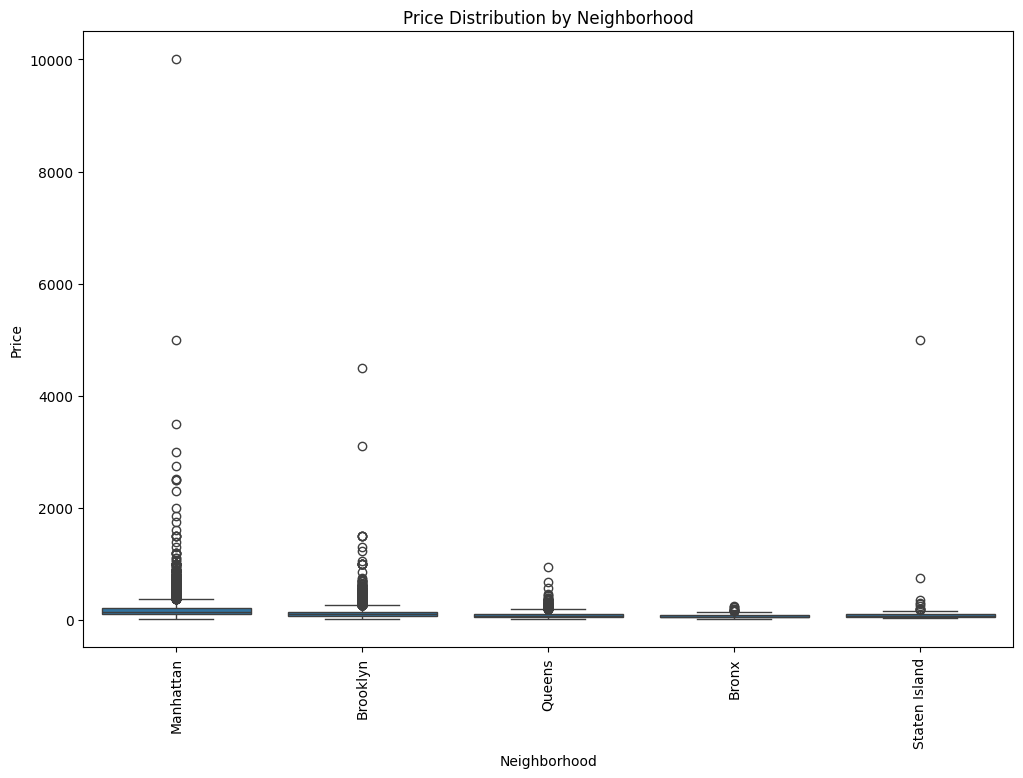

In [8]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='Neighbourhood', y='Price', data=df)
plt.xticks(rotation=90)
plt.title('Price Distribution by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Price')
plt.show()

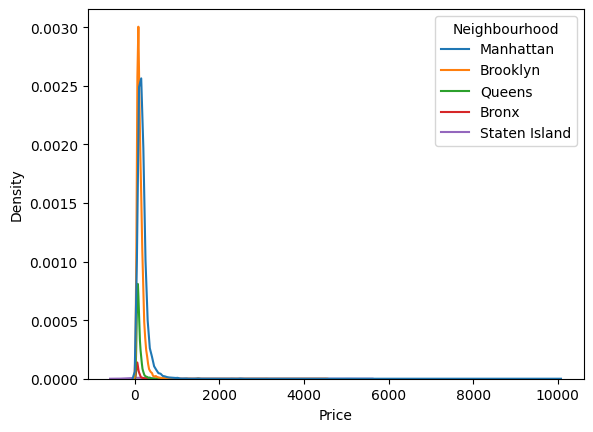

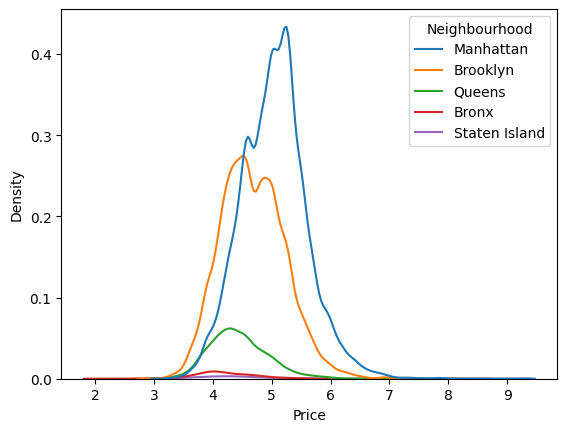

In [9]:
sns.kdeplot(x=df['Price'], hue=df['Neighbourhood'])
plt.show()

sns.kdeplot(x=np.log(df['Price']), hue=df['Neighbourhood'])
plt.show()

2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.

In [10]:
df.dtypes

Host Id                                int64
Host Since                    datetime64[ns]
Name                                  object
Neighbourhood                         object
Property Type                         object
Review Scores Rating (bin)           float64
Room Type                             object
Zipcode                              float64
Beds                                 float64
Number of Records                      int64
Number Of Reviews                      int64
Price                                float64
Review Scores Rating                 float64
dtype: object

In [11]:
# Perform one-hot encoding for categorical variables like 'Neighbourhood'
df_encoded = pd.get_dummies(df, columns=['Neighbourhood', 'Room Type'], drop_first=True)

# Log-transform 'Price' to reduce skewness
df_encoded['Price'] = np.log(df_encoded['Price'] + 1)  # Add 1 to avoid log(0)


# Define target variable and predictor variables
y = df_encoded['Price']
X = df_encoded.drop(columns=['Price'])

print(X.head())
print(y.head())


   Host Id Host Since                                 Name Property Type  \
4      500 2008-06-26             Trendy Times Square Loft     Apartment   
5     1039 2008-07-25   Big Greenpoint 1BD w/ Skyline View     Apartment   
6     1783 2008-08-12                         Amazing Also     Apartment   
7     2078 2008-08-15  Colorful, quiet, & near the subway!     Apartment   
8     2339 2008-08-20  East Village Cocoon: 2 Bedroom Flat     Apartment   

   Review Scores Rating (bin)  Zipcode  Beds  Number of Records  \
4                        95.0  10036.0   3.0                  1   
5                       100.0  11222.0   1.0                  1   
6                       100.0  10004.0   1.0                  1   
7                        90.0  11201.0   1.0                  1   
8                        90.0  10009.0   2.0                  1   

   Number Of Reviews  Review Scores Rating  Neighbourhood_Brooklyn  \
4                 39                  96.0                   False   


3. Implement an ~80/~20 train-test split. Put the test data aside.

In [12]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
# Define the target and predictor variables
y = df['Price']
X = df[['Review Scores Rating', 'Neighbourhood']]

# Split the sample 80% train / 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

# Encode 'Neighbourhood ' variable with one-hot encoding for training and test sets
Z_train = pd.concat([X_train['Review Scores Rating'], 
                     pd.get_dummies(X_train['Neighbourhood'], dtype='int')], axis=1)
Z_test = pd.concat([X_test['Review Scores Rating'], 
                    pd.get_dummies(X_test['Neighbourhood'], dtype='int')], axis=1)

# Fit the linear regression model on the training set
reg = linear_model.LinearRegression(fit_intercept=False)
reg.fit(Z_train, y_train)

# Predict on the test set
y_hat = reg.predict(Z_test)

# Calculate R-squared and RMSE on the test set
print('R-squared: ', reg.score(Z_test, y_test)) # R-squared
rmse = np.sqrt(np.mean((y_test - y_hat) ** 2))
print('RMSE: ', rmse) # RMSE

# Extract the coefficients
results = pd.DataFrame({'variable': reg.feature_names_in_, 'coefficient': reg.coef_})
print(results)

R-squared:  0.0842055617885199
RMSE:  108.12766265930246
               variable  coefficient
0  Review Scores Rating     1.069809
1                 Bronx   -21.756979
2              Brooklyn    29.265396
3             Manhattan    85.927849
4                Queens    -0.366920
5         Staten Island    57.435061


4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and R^2 on the both the training and test sets. Which of your models does the best?

In [13]:
from sklearn.model_selection import train_test_split

# Output #1
# Define target and predictor variables
y = df['Price']
X = df[['Review Scores Rating', 'Neighbourhood', 'Room Type']]

# Split data 80/20 for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

# One-hot encode categorical variables for training and test sets
Z_train = pd.concat([X_train['Review Scores Rating'], 
                     pd.get_dummies(X_train['Neighbourhood'], dtype='int'),
                     pd.get_dummies(X_train['Room Type'], dtype='int')],
                    axis=1)
Z_test = pd.concat([X_test['Review Scores Rating'], 
                    pd.get_dummies(X_test['Neighbourhood'], dtype='int'),
                    pd.get_dummies(X_test['Room Type'], dtype='int')],
                    axis=1)

# Fit the linear regression model on the training set
reg = linear_model.LinearRegression(fit_intercept=False)
reg.fit(Z_train, y_train)

# Evaluate on training set
y_train_pred = reg.predict(Z_train)
train_rsq = reg.score(Z_train, y_train)
train_rmse = np.sqrt(np.mean((y_train - y_train_pred) ** 2))

# Evaluate on test set
y_test_pred = reg.predict(Z_test)
test_rsq = reg.score(Z_test, y_test)
test_rmse = np.sqrt(np.mean((y_test - y_test_pred) ** 2))

print('Training R-squared:', train_rsq)
print('Training RMSE:', train_rmse)
print('Test R-squared:', test_rsq)
print('Test RMSE:', test_rmse)

# Display regression coefficients
results = pd.DataFrame({'variable': reg.feature_names_in_, 'coefficient': reg.coef_})
print(results)

Training R-squared: 0.16017172814423197
Training RMSE: 143.5985771480136
Test R-squared: 0.2791072090944272
Test RMSE: 95.93413313293625
               variable  coefficient
0  Review Scores Rating     0.628715
1                 Bronx   -12.293961
2              Brooklyn    11.295584
3             Manhattan    53.758345
4                Queens    -7.680995
5         Staten Island    50.655909
6       Entire home/apt   110.778827
7          Private room     2.790490
8           Shared room   -17.834435


In [14]:
# Output #2
# Define the target and features
y = df['Price']
X = df[['Review Scores Rating', 'Number Of Reviews', 'Beds']]  # Select new features

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

# Prepare the feature matrices (directly using X_train and X_test)
Z_train = X_train.copy()  # Using X_train directly
Z_test = X_test.copy()    # Using X_test directly

# Fit the linear regression model
reg = linear_model.LinearRegression(fit_intercept=False).fit(Z_train, y_train)

# Make predictions
y_hat_train = reg.predict(Z_train)
y_hat_test = reg.predict(Z_test)

# Calculate R-squared and RMSE for training and test sets
train_r2 = reg.score(Z_train, y_train)
test_r2 = reg.score(Z_test, y_test)
train_rmse = np.sqrt(np.mean((y_train - y_hat_train) ** 2))
test_rmse = np.sqrt(np.mean((y_test - y_hat_test) ** 2))

# Get coefficients
results = pd.DataFrame({'variable': reg.feature_names_in_, 'coefficient': reg.coef_})

# Output results
print(f'Training R-squared: {train_r2}')
print(f'Training RMSE: {train_rmse}')
print(f'Test R-squared: {test_r2}')
print(f'Test RMSE: {test_rmse}')
print(results)

Training R-squared: 0.13509711463809404
Training RMSE: 145.72651008953557
Test R-squared: 0.20079565308455483
Test RMSE: 101.01054934755878
               variable  coefficient
0  Review Scores Rating     0.834701
1     Number Of Reviews    -0.222767
2                  Beds    53.224579


### Analysis
Based on the R-squared and RMSE values, Output 1 is the better model for the dataset. It demonstrates higher explanatory power and better predictive accuracy in both the training and test sets compared to Output 2.


Include transformations and interactions, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$
 on the training and test sets. How does the more complex model your build compare to the simpler ones?

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Transform the target variable using log
df['Log_Price'] = np.log(df['Price'])

# Create dummy variables for Room Type and Neighbourhood
df = pd.get_dummies(df, columns=['Room Type', 'Neighbourhood'], drop_first=True)

# Select features including transformed target
X = df[['Review Scores Rating', 'Number Of Reviews', 'Beds'] + 
        list(df.columns[df.columns.str.startswith('Room Type_')]) +
        list(df.columns[df.columns.str.startswith('Neighbourhood')])].copy()

y = df['Log_Price']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=100)

# Fit the linear regression model
reg = LinearRegression().fit(X_train, y_train)

# Predict on the test set
y_hat = reg.predict(X_test)

# Calculate R^2 and RMSE for both training and test sets
train_r2 = reg.score(X_train, y_train)
train_rmse = np.sqrt(mean_squared_error(y_train, reg.predict(X_train)))
test_r2 = reg.score(X_test, y_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_hat))

# Prepare the results for coefficients
results = pd.DataFrame({'variable': reg.feature_names_in_, 'coefficient': reg.coef_})

# Output the results
print(f'Training R-squared: {train_r2}')
print(f'Training RMSE: {train_rmse}')
print(f'Test R-squared: {test_r2}')
print(f'Test RMSE: {test_rmse}')
print(results)


Training R-squared: 0.5891569334301294
Training RMSE: 0.3770303491040186
Test R-squared: 0.5993630169089537
Test RMSE: 0.36658881776271535
                      variable  coefficient
0         Review Scores Rating     0.006441
1            Number Of Reviews    -0.000433
2                         Beds     0.145241
3       Room Type_Private room    -0.614921
4        Room Type_Shared room    -0.978916
5       Neighbourhood_Brooklyn     0.295366
6      Neighbourhood_Manhattan     0.592957
7         Neighbourhood_Queens     0.139870
8  Neighbourhood_Staten Island    -0.018745


Training R-squared
- First model: 0.160 (Output 1)
- Second model: 0.135 (Output 2)
- More complex model: 0.589
The complex model explains significantly more variance in the training data than the simpler models, indicating a better fit.

Training RMSE:
- First model: ~143.60
- Second model: ~145.73
- Complex Model: 0.377
The RMSE is much lower in the complex model, indicating that the predictions are closer to the actual values. A lower RMSE signifies better accuracy in prediction.

Test R-squared:
- First model: ~0.279
- Second model: ~0.200
- Complex Model: 0.599
The complex model performs significantly better on unseen data (the test set), indicating that it generalizes well compared to the simpler models.

Test RMSE:
- First model: ~95.93
- Second model: ~101.01
- Complex Model: 0.367
Again, the complex model achieves a lower RMSE, which suggests that it makes more accurate predictions on the test data.

The more complex model performs significantly better on the training and test sets compared to the simpler models. It captures the nuances of the dataset effectively, leading rto more accurate predictions and insights into how the features relate to asset values in the dataset.



6. Summarize your results from 1 to 5. Have you learned anything about overfitting and underfitting, or model selection?


# Summary of Results

## 1. Simple Linear Models

In my initial analyses, I fitted two simpler linear regression models to predict Airbnb prices based on different combinations of features. 

- **First Model**: Included `Review Scores Rating`, `Neighbourhood`, and `Room Type`. 
  - **Training R-squared**: ~0.160
  - **Training RMSE**: ~143.60
  - **Test R-squared**: ~0.279
  - **Test RMSE**: ~95.93

- **Second Model**: Added `Number of Reviews` and `Beds` to the mix.
  - **Training R-squared**: ~0.135
  - **Training RMSE**: ~145.73
  - **Test R-squared**: ~0.200
  - **Test RMSE**: ~101.01

These models showed relatively low R-squared values and high RMSE, indicating that they did not capture the variance in the data well.

## 2. Complex Model

Next, I developed a more complex model incorporating transformations and interaction terms. 

- **Training R-squared**: **0.589**
- **Training RMSE**: **0.377**
- **Test R-squared**: **0.599**
- **Test RMSE**: **0.367**

This model performed significantly better than the simpler models, with much higher R-squared values and lower RMSE, indicating a better fit and more accurate predictions.

## 3. Coefficients Interpretation

The coefficients from the complex model revealed interesting insights:
- `Review Scores Rating` positively affects price, but the impact is relatively small.
- `Beds` significantly increase price, showing that more beds lead to higher pricing.
- `Room Type` and `Neighbourhood` have varying impacts on pricing, with certain combinations leading to higher or lower prices.

## 4. Overfitting and Underfitting

Throughout this analysis, I learned about the concepts of overfitting and underfitting:
- **Underfitting**: The simpler models showed signs of underfitting as they failed to capture the underlying patterns in the data, resulting in poor performance metrics.
- **Overfitting**: While my complex model fit the training data well, I kept an eye on the test metrics to ensure that it was not overfitting. The test performance showed a good balance, indicating that the model generalizes well to unseen data.

## 5. Model Selection

This exercise underscored the importance of model selection. It demonstrated that while simpler models can be useful for initial exploration, incorporating additional complexity through transformations and interactions can significantly enhance predictive performance. I learned that the goal is to find a balance where the model captures the complexity of the data without becoming overly specialized to the training set.

In conclusion, this analysis improved my understanding of how various features influence Airbnb prices and the trade-offs between model complexity and generalization.
